# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
pip install gTTS

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install playsound

Note: you may need to restart the kernel to use updated packages.


In [4]:
#Import all the required libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from skimage import io
pd.set_option('display.max_colwidth', -1)

import collections
from wordcloud import WordCloud, STOPWORDS

import tensorflow as tf
import keras
from keras.preprocessing.image import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from tqdm import tqdm
from PIL import Image

from gtts import gTTS
from playsound import playsound
from IPython import display

Using TensorFlow backend.
W0517 08:51:30.990846 140043151873856 playsound.py:253] playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [5]:
#Import the dataset and read the image into a seperate variable

images='Flickr8K/Images/'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [6]:
all_imgs

['Flickr8K/Images/2201222219_8d656b0633.jpg',
 'Flickr8K/Images/3681172959_6674c118d2.jpg',
 'Flickr8K/Images/3257107194_f235c8f7ab.jpg',
 'Flickr8K/Images/2831656774_36982aafdb.jpg',
 'Flickr8K/Images/3718892835_a3e74a3417.jpg',
 'Flickr8K/Images/3360930596_1e75164ce6.jpg',
 'Flickr8K/Images/2735792721_b8fe85e803.jpg',
 'Flickr8K/Images/3537520829_aab733e16c.jpg',
 'Flickr8K/Images/2544246151_727427ee07.jpg',
 'Flickr8K/Images/2215136723_960edfea49.jpg',
 'Flickr8K/Images/2403078014_4b1d6f8bde.jpg',
 'Flickr8K/Images/557721978_dfde31bc02.jpg',
 'Flickr8K/Images/2052702658_da1204f6d1.jpg',
 'Flickr8K/Images/3497106366_d1a256e723.jpg',
 'Flickr8K/Images/2057305043_952b8dc82c.jpg',
 'Flickr8K/Images/2552816307_c7c8e7f6b4.jpg',
 'Flickr8K/Images/3702436188_2c26192fd0.jpg',
 'Flickr8K/Images/2706023395_ac9eba0e42.jpg',
 'Flickr8K/Images/1084040636_97d9633581.jpg',
 'Flickr8K/Images/3108732084_565b423162.jpg',
 'Flickr8K/Images/2991771557_d98fa0a69f.jpg',
 'Flickr8K/Images/3212085754_35fdc9

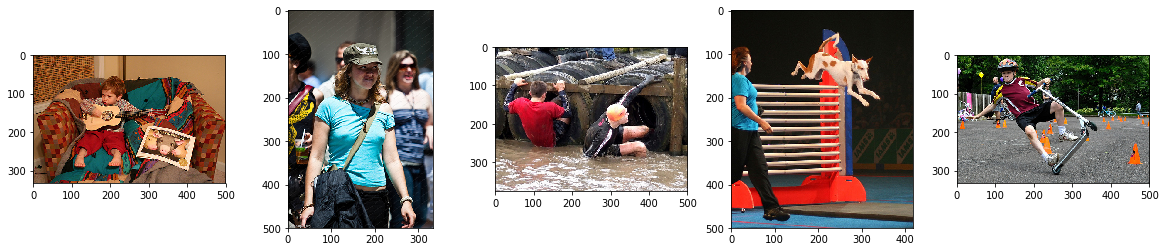

In [7]:
#Visualise both the images & text present in the dataset
Display_Images = all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)

for ax, image in zip(axes, Display_Images):
    ax.imshow(io.imread(image), cmap=None)

In [8]:
#Import the dataset and read the text file into a seperate variable
text_file = 'Flickr8K/captions.txt' #storing captions in a separate variable
def load_doc(text_file):
    
    open_file = open(text_file, 'r', encoding = 'latin-1')
    text = open_file.read()
    open_file.close()
    
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [9]:
image_path = 'Flickr8K/Images/'
all_img_id = [] #store all the image id here
all_img_vector = [] #store all the image path here
annotations = [] #store all the captions here

with open('Flickr8K/captions.txt', 'r') as fo:
    next(fo) # to skip the heading
    for line in fo:
        split_arr = line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.')) #stripping \n and fullstop
        all_img_vector.append(image_path+split_arr[0])
        
df = pd.DataFrame(list(zip(all_img_id, all_img_vector, annotations)), columns = ['ID', 'Path', 'Captions'])
df

ID                                       Path  \
0      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
...                          ...                                        ...   
40450  997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg    
40451  997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg    
40452  997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg    
40453  997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg    
40454  997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg    

                                                                         Captions  
0      A child in a pink dress is climbing up a set of stairs in an entry way      
1      A girl going into a wooden building                                         
2      A little girl climbing into a wooden playhouse                              
3      A little girl climbing the stairs to her playhouse                          
4      A little girl in a pink dress going into a wooden cabin                     
...                                                         ...                    
40450  A man in a pink shirt climbs a rock face                                    
40451  A man is rock climbing high in the air                                      
40452  A person in a red shirt climbing up a rock face covered in assist handles   
40453  A rock climber in a red shirt                                               
40454  A rock climber practices on a rock climbing wall                            

[40455 rows x 3 columns]

In [10]:
len(annotations)

40455

In [11]:
type(annotations)

list

In [12]:
vocabulary = [word for line in annotations for word in line.split()]
vocabulary

['A',
 'child',
 'in',
 'a',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'a',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 'A',
 'girl',
 'going',
 'into',
 'a',
 'wooden',
 'building',
 'A',
 'little',
 'girl',
 'climbing',
 'into',
 'a',
 'wooden',
 'playhouse',
 'A',
 'little',
 'girl',
 'climbing',
 'the',
 'stairs',
 'to',
 'her',
 'playhouse',
 'A',
 'little',
 'girl',
 'in',
 'a',
 'pink',
 'dress',
 'going',
 'into',
 'a',
 'wooden',
 'cabin',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'spotted',
 'dog',
 'are',
 'fighting',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'tri-colored',
 'dog',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'the',
 'road',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'white',
 'dog',
 'with',
 'brown',
 'spots',
 'are',
 'staring',
 'at',
 'each',
 'other',
 'in',
 'the',
 'street',
 'Two',
 'dogs',
 'of',
 'different',
 'breeds',
 'looking',
 'at',
 'each',
 'other',
 'on',
 'the',
 'road',
 'Two',
 'dogs',
 'on',
 'pavement',
 'moving',
 'towa

**We can see that we had both A and a are counted separately. So let's convert all words to lower case.**

In [13]:
#Create the vocabulary & the counter for the captions
vocabulary = [word.lower() for line in annotations for word in line.split()] # we can see that we had both

val_count = collections.Counter(vocabulary)
val_count

Counter({'a': 60196,
         'child': 1507,
         'in': 18174,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 2325,
         'entry': 1,
         'way': 48,
         'girl': 3277,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1736,
         'playhouse': 6,
         'the': 17507,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3620,
         'dog': 7948,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7304,
         'each': 399,
         'other': 667,
         'on': 10357,
         'road': 380,
         'white': 3706,
         'brown': 2457,
         'spots': 28,
         'staring': 57,
         'at': 2810,
         'stree

- So we have successfully created a list containing all captions as well as a dataframe which contains all images along with their respective paths and captions. Each image has 5 captions associated with it.
- Hence, total images = 8091
- Therefore, total captions: 8091*5 = 40455

In [14]:
#check total captions and images present in dataset
print('Total captions present in the dataset: '+str(len(annotations)))
print('Total images present in the dataset: '+str(len(all_imgs)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


## Visualizing Images and their respective captions in the dataset

a :  60196
in :  18174
the :  17507
on :  10357
is :  9069
and :  8057
dog :  7948
with :  7304
man :  7137
of :  6495
two :  5132
white :  3706
black :  3620
boy :  3514
are :  3365
woman :  3304
girl :  3277
to :  3005
wearing :  2916
people :  2811
at :  2810
water :  2676
young :  2587
red :  2553
brown :  2457
an :  2325
his :  2255
blue :  2125
dogs :  2095
running :  1996


Text(0, 0.5, 'Count')

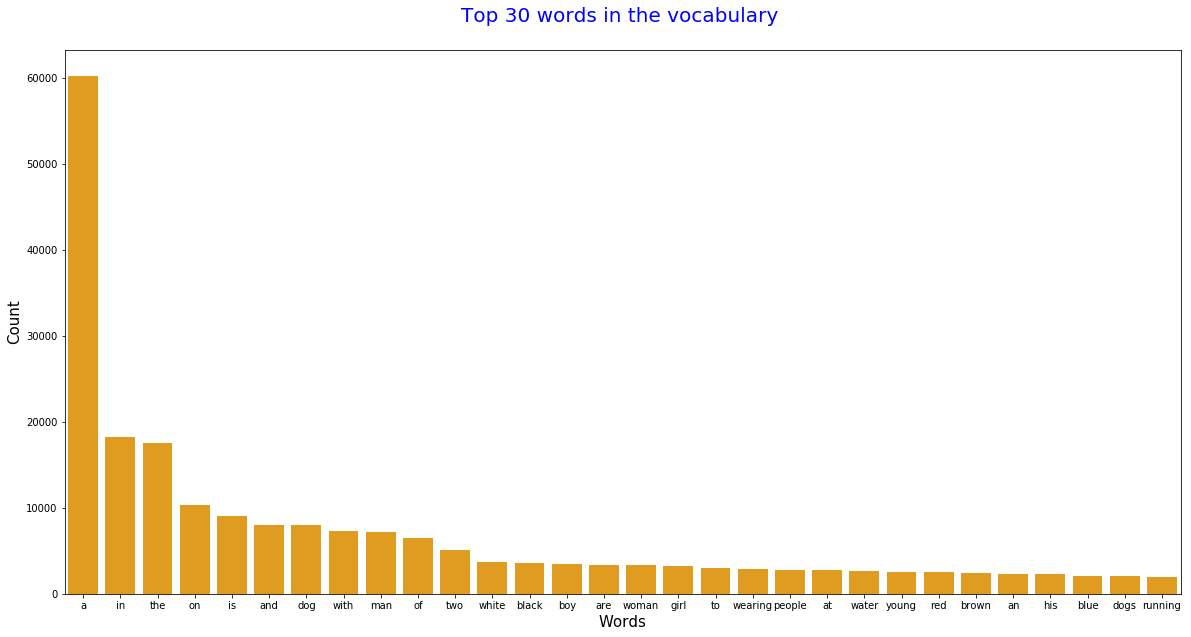

In [15]:
# Visualize the top 30 ocuuring words in the captions

for word, count in val_count.most_common(30):
    print(word, ': ', count)
    
lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
plt.figure(figsize = (20,10))
#most_common_words_df.plot.bar(x = 'Word', y = 'Count', width = 0.6, color = 'orange')
sns.barplot(x = 'Word', y = 'Count', data = most_common_words_df, color = 'orange')
plt.title('Top 30 words in the vocabulary \n', color = 'b', size = 20)
plt.xlabel('Words', size = 15)
plt.ylabel('Count', size = 15)

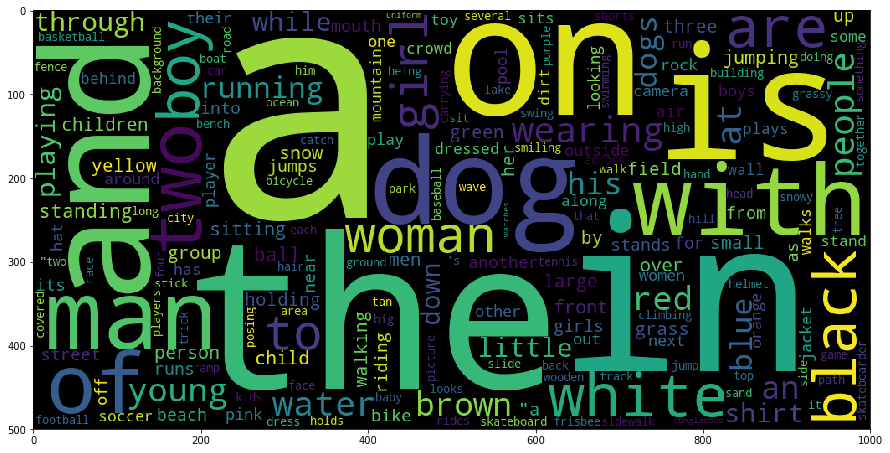

In [16]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(val_count)
plt.figure(figsize = (15,10))
plt.imshow(wordcloud)
plt.show()

**We can see that stopwords are having higher frequency**

dog :  7948
man :  7137
two :  5132
white :  3706
black :  3620
boy :  3514
woman :  3304
girl :  3277
wearing :  2916
people :  2811
water :  2676
young :  2587
red :  2553
brown :  2457
blue :  2125
dogs :  2095
running :  1996
playing :  1954
little :  1736
shirt :  1735
standing :  1702
ball :  1678
grass :  1565
person :  1515
child :  1507
snow :  1439
jumping :  1430
front :  1322
sitting :  1322
small :  1257


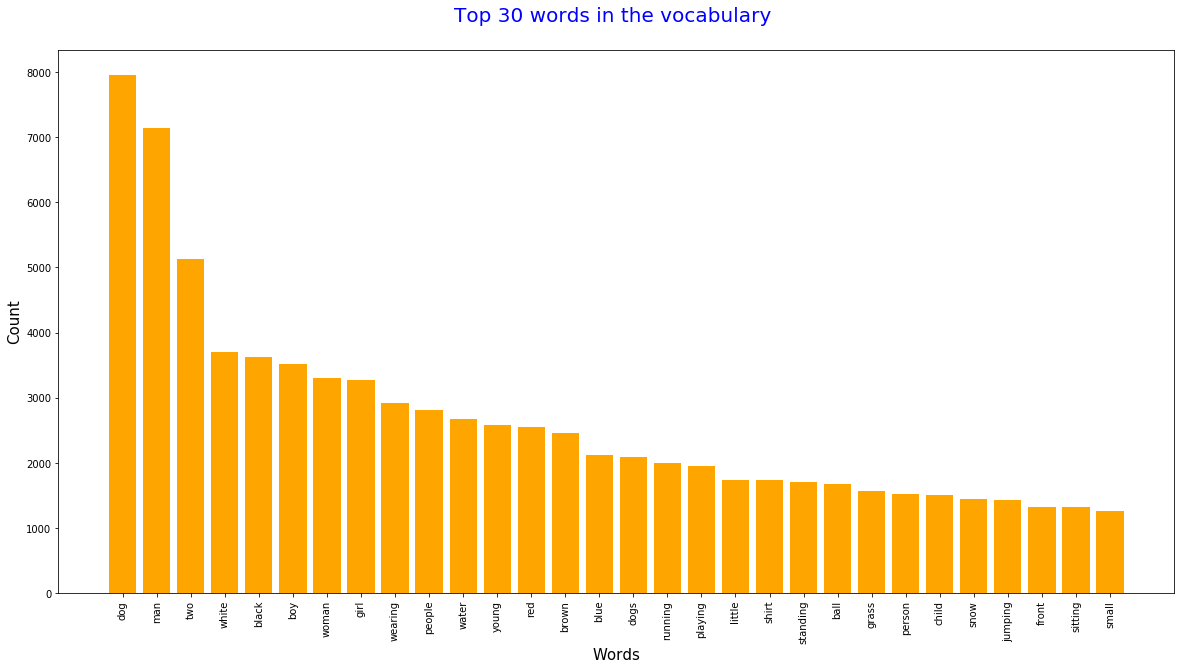

In [17]:
#Visualise the top 30 occuring words in the captions
for word, count in val_count.most_common(47):
    if word not in STOPWORDS:
        print(word, ": ", count)

dict_without_stopwords = {}
for word, count in val_count.most_common(47):
    if word not in STOPWORDS:
        dict_without_stopwords[word] = count
plt.figure(figsize = (20,10))        
plt.bar(range(len(dict_without_stopwords)), dict_without_stopwords.values(), align = 'center', color = 'orange')
plt.xticks(range(len(dict_without_stopwords)), list(dict_without_stopwords.keys()))
plt.title('Top 30 words in the vocabulary \n', color = 'b', size = 20)
plt.xlabel('Words', size = 15)
plt.ylabel('Count', size = 15)
plt.xticks(rotation = 90)
plt.show()

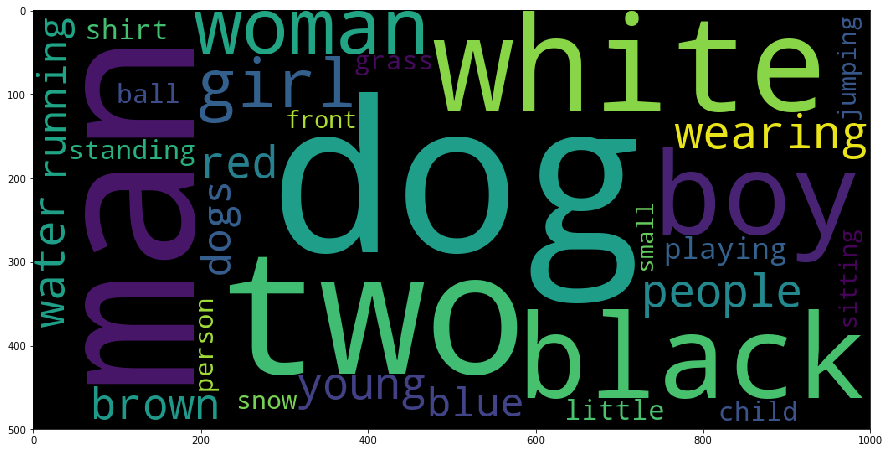

In [18]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(dict_without_stopwords)
plt.figure(figsize = (15,10))
plt.imshow(wordcloud)
plt.show()

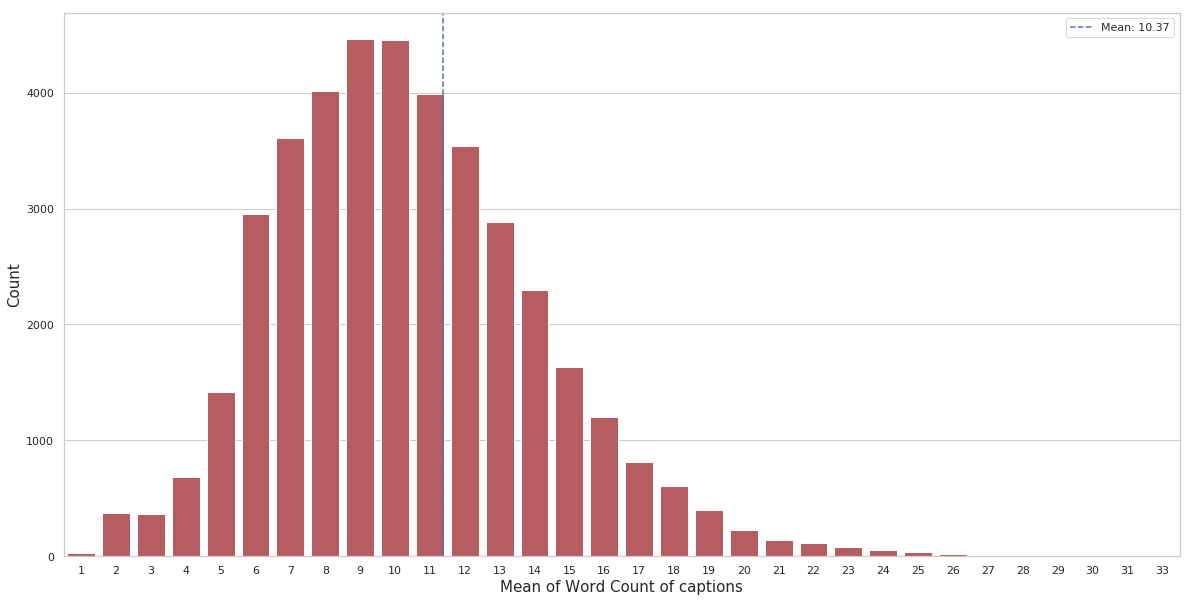

In [19]:
caption_df = df.copy()
caption_df['caption_word_count'] = caption_df['Captions'].str.split().str.len()

mean = sum(caption_df['caption_word_count'])/len(caption_df['caption_word_count'])

sns.set(style = 'whitegrid', font_scale = 1)
plt.figure(figsize = (20,10))
ax = sns.countplot(caption_df['caption_word_count'], color = 'r')
plt.xlabel('Mean of Word Count of captions', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
ax.axvline(mean, color = 'b', linestyle = '--')
plt.legend({'Mean: {:.2f}'.format(mean): mean})
plt.show()

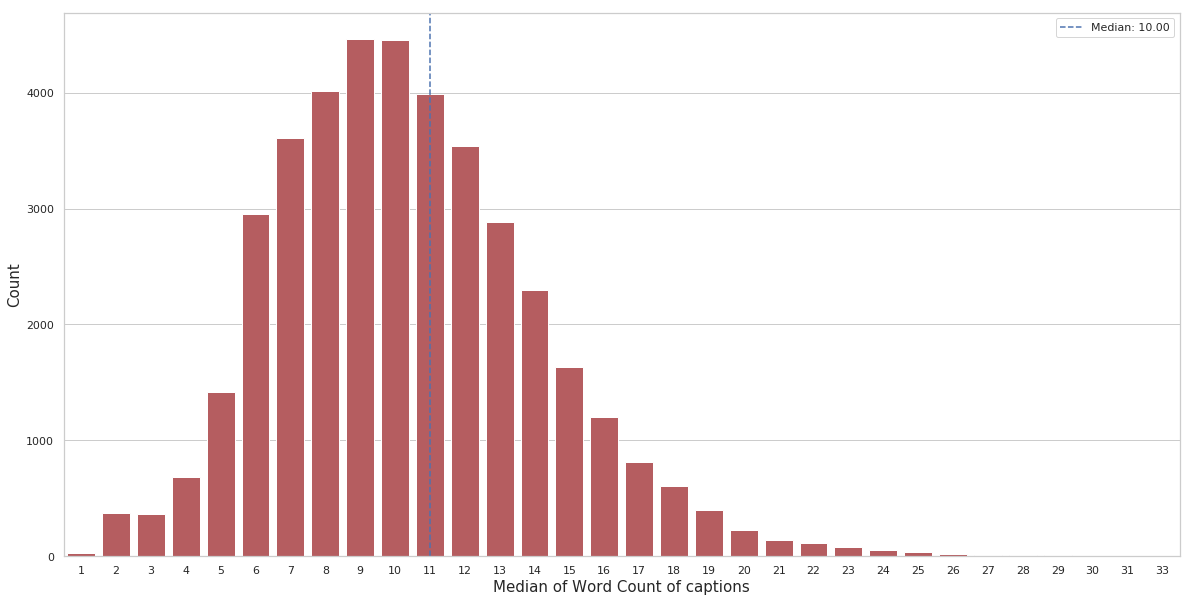

In [20]:
mean = np.median(caption_df['caption_word_count'])

sns.set(style = 'whitegrid', font_scale = 1)
plt.figure(figsize = (20,10))
ax = sns.countplot(caption_df['caption_word_count'], color = 'r')
plt.xlabel('Median of Word Count of captions', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
ax.axvline(mean, color = 'b', linestyle = '--')
plt.legend({'Median: {:.2f}'.format(mean): mean})
plt.show()

**We can see most of the captions have 10 to 11 words**

## Visualizing both images & captions together

In [21]:
def plot_image_captions(Pathlist, captionsList, fig, count = 2, npix = 299, nimg = 2):
    image_load = load_img(Path, target_size = (npix, npix, 3))
    ax = fig.add_subplot(nimg, 2, count, xticks = [], yticks = [])
    ax.imshow(image_load)
    
    count += 1
    ax = fig.add_subplot(nimg, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize = 20)

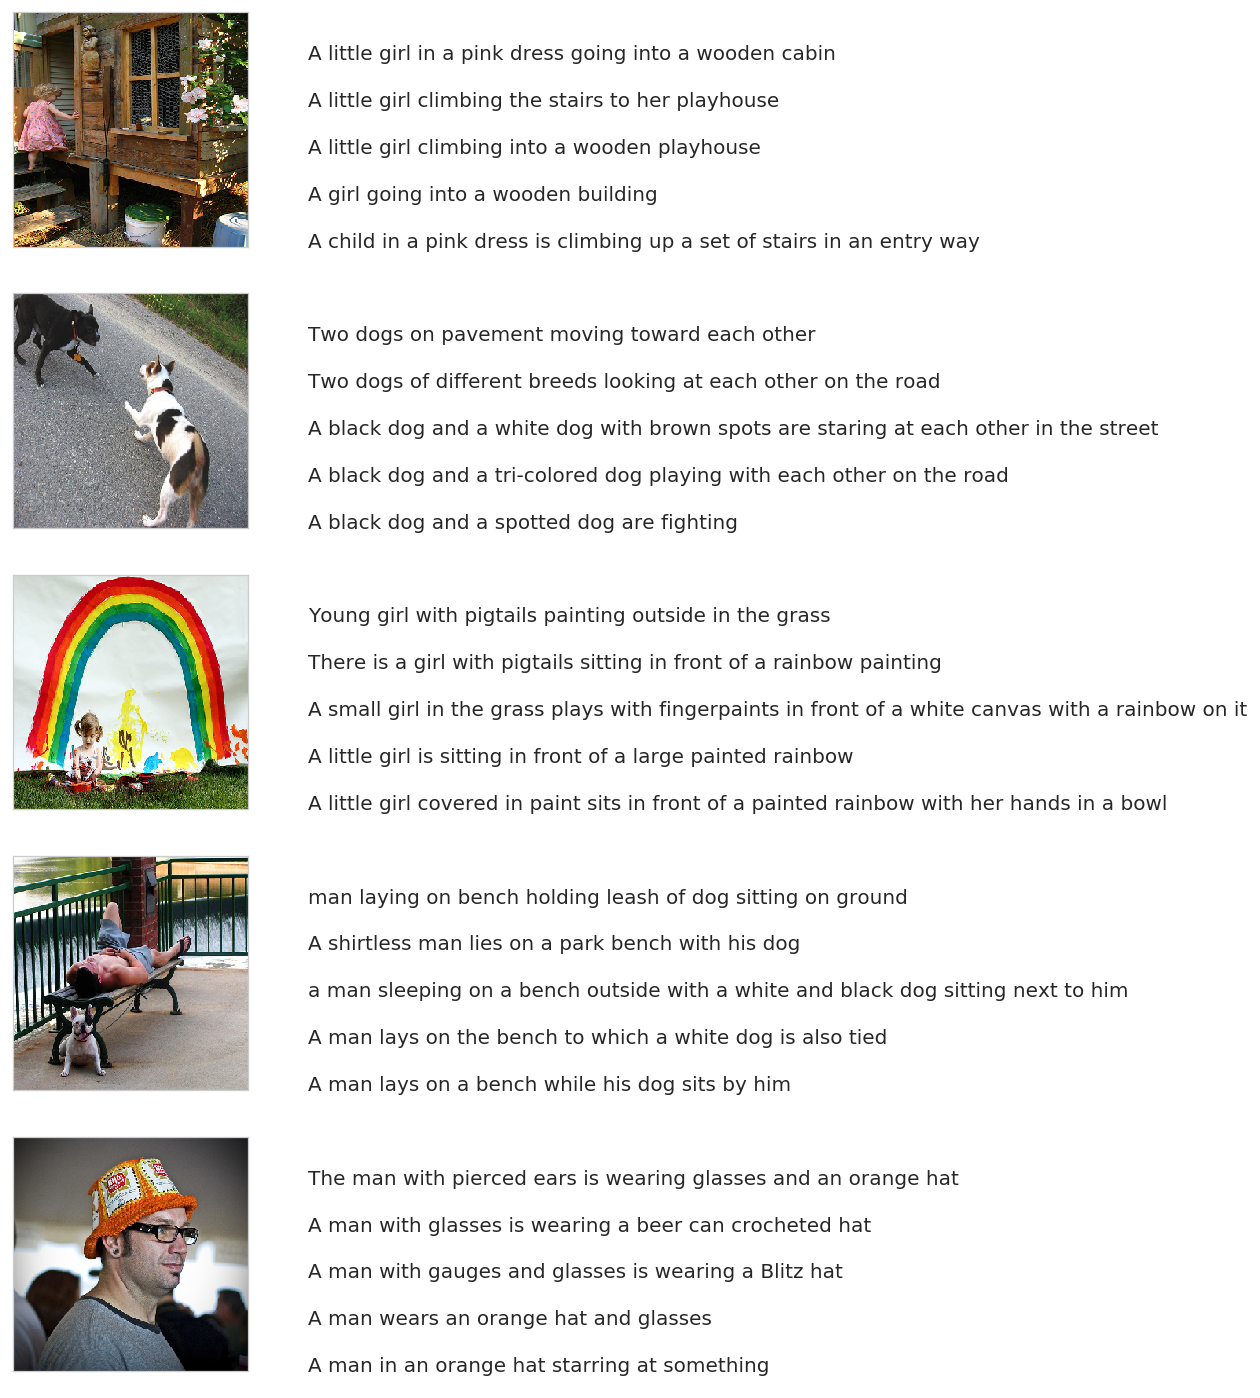

In [22]:



fig = plt.figure(figsize = (10,25)) # For displaying image
count = 1

for Path in df[:25].Path.unique():
    captions = list(df['Captions'].loc[df.Path== Path].values)
    plot_image_captions(Path,captions,fig,count,299,5)
    count += 2
plt.show()

## Data Cleaning

- Converting all words to lower case
- Removing punctuations
- Retaining only words by removing numbers
- We are not removing stopwords but removing hanging s, a or any one letter word.
- We are not performing stemming

In [23]:
# Data Cleaning
# Prepare translation table for removing punctuation
remove_punctuation = str.maketrans('', '', string.punctuation)
for i in range(len(annotations)):
    line = annotations[i]
    line = line.split()
    line = [word.lower() for word in line]
    line = [word.translate(remove_punctuation) for word in line]
    line = [word for word in line if len(word)>1]
    line = [word for word in line if word.isalpha()]
    annotations[i] = ' '.join(line)

In [24]:
#Create a list which contains all the captions

#Add the <start> & <end> token to all those captions as well
annotations = ['<start>' + ' ' + line + ' ' + '<end>' for line in annotations]

#Create a list which contains all the path to the images
all_img_path = all_img_vector

#check total captions and images present in dataset
print('Total captions present in the dataset: '+str(len(annotations)))
print('Total images present in the dataset: '+str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [25]:
annotations[0:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [26]:
# create the tokenizer
top_voc = 5000
#your code here
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_voc+1, filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                                                 lower = True, char_level = False, oov_token = 'UNK')

tokenizer.fit_on_texts(annotations)

train_seqs = tokenizer.texts_to_sequences(annotations)

tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [27]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [28]:
tokenizer.index_word

{1: 'UNK',
 2: '<start>',
 3: '<end>',
 4: 'in',
 5: 'the',
 6: 'on',
 7: 'is',
 8: 'and',
 9: 'dog',
 10: 'with',
 11: 'man',
 12: 'of',
 13: 'two',
 14: 'white',
 15: 'black',
 16: 'boy',
 17: 'are',
 18: 'woman',
 19: 'girl',
 20: 'to',
 21: 'wearing',
 22: 'people',
 23: 'at',
 24: 'water',
 25: 'young',
 26: 'red',
 27: 'brown',
 28: 'an',
 29: 'his',
 30: 'blue',
 31: 'dogs',
 32: 'running',
 33: 'through',
 34: 'playing',
 35: 'while',
 36: 'down',
 37: 'little',
 38: 'shirt',
 39: 'standing',
 40: 'ball',
 41: 'grass',
 42: 'person',
 43: 'child',
 44: 'snow',
 45: 'jumping',
 46: 'over',
 47: 'three',
 48: 'front',
 49: 'sitting',
 50: 'small',
 51: 'field',
 52: 'up',
 53: 'holding',
 54: 'large',
 55: 'group',
 56: 'by',
 57: 'green',
 58: 'yellow',
 59: 'children',
 60: 'walking',
 61: 'men',
 62: 'her',
 63: 'into',
 64: 'beach',
 65: 'air',
 66: 'near',
 67: 'jumps',
 68: 'mouth',
 69: 'street',
 70: 'runs',
 71: 'for',
 72: 'another',
 73: 'riding',
 74: 'from',
 75: 'it

In [29]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('child', 1517),
             ('in', 18182),
             ('pink', 702),
             ('dress', 332),
             ('is', 9069),
             ('climbing', 490),
             ('up', 1215),
             ('set', 105),
             ('of', 6496),
             ('stairs', 109),
             ('an', 2358),
             ('entry', 1),
             ('way', 48),
             ('<end>', 40455),
             ('girl', 3284),
             ('going', 145),
             ('into', 1046),
             ('wooden', 278),
             ('building', 485),
             ('little', 1750),
             ('playhouse', 6),
             ('the', 17676),
             ('to', 3005),
             ('her', 1102),
             ('cabin', 4),
             ('black', 3627),
             ('dog', 7956),
             ('and', 8057),
             ('spotted', 36),
             ('are', 3365),
             ('fighting', 130),
             ('tricolored', 12),
             ('playing', 1954),
        

In [30]:
train_seqs[:5] #First 5 instance

[[2, 43, 4, 88, 169, 7, 115, 52, 390, 12, 382, 4, 28, 1, 687, 3],
 [2, 19, 309, 63, 193, 119, 3],
 [2, 37, 19, 115, 63, 193, 2354, 3],
 [2, 37, 19, 115, 5, 382, 20, 62, 2354, 3],
 [2, 37, 19, 4, 88, 169, 309, 63, 193, 2889, 3]]

In [31]:
annotations[:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [32]:
print(len(train_seqs))
print(type(train_seqs))

40455
<class 'list'>


<start> :  40455
<end> :  40455
in :  18182
the :  17676
on :  10367
is :  9069
and :  8057
dog :  7956
with :  7308
man :  7164
of :  6496
two :  5546
white :  3710
black :  3627
boy :  3534
are :  3365
woman :  3320
girl :  3284
to :  3005
wearing :  2917
people :  2837
at :  2819
water :  2676
young :  2610
red :  2553
brown :  2471
an :  2358
his :  2255
blue :  2125
dogs :  2097


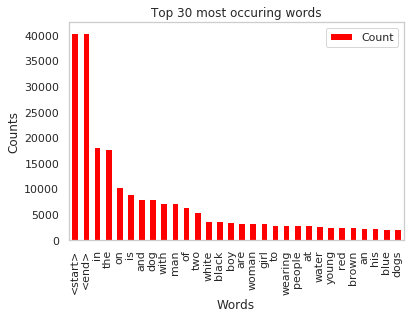

In [33]:
# Create a word count of your tokenizer to visualize the Top 30 occuring words after text processing

# your code here
tokenizer_top_words = [word for line in annotations for word in line.split()]
tokenizer_top_words_count = collections.Counter(tokenizer_top_words)
tokenizer_top_words_count

for word, count in tokenizer_top_words_count.most_common(30):
    print(word, ': ', count)
    
token_lst = tokenizer_top_words_count.most_common(30)
most_common_words_df = pd.DataFrame(token_lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x = 'Word', y = 'Count', width = 0.6, color = 'red')
plt.title('Top 30 most occuring words')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.grid(b=None)

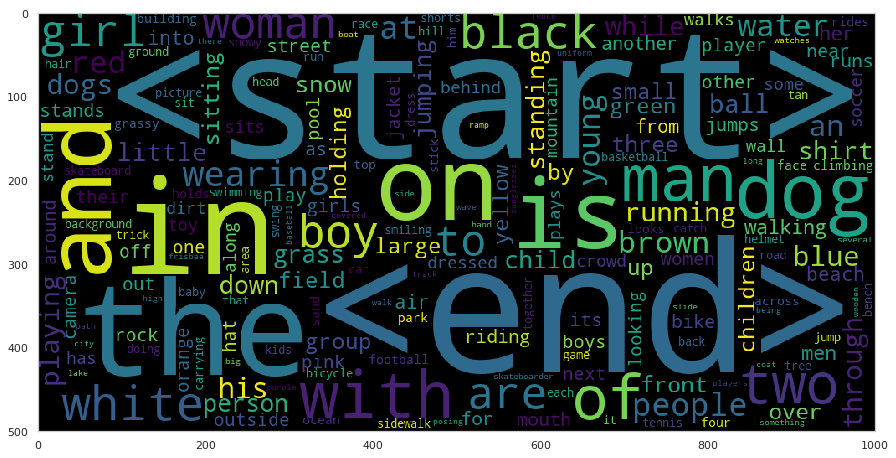

In [34]:
wordcloud_token = WordCloud(width = 1000, height = 500).generate_from_frequencies(tokenizer_top_words_count)
plt.figure(figsize = (15,10))
plt.imshow(wordcloud_token)
plt.grid(b=None)

In [35]:
# Pad each vector to the max_length of the captions ^ store it to a variable
train_seqs_len = [len(seq) for seq in train_seqs]
longest_word_length = max(train_seqs_len)

# Calculate the longest_word_length to pad all sequences to be the same length as the longest one.

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding = 'post', maxlen = longest_word_length,
                                                          dtype = 'int32', value = 0)

print('The shape of Caption vector is: ' + str(cap_vector.shape))

The shape of Caption vector is: (40455, 31)


We are padding zero at last using padding = 'post'. We know that start token acts as prompter and it expect some word after that. Zero indicates no word and have no value at beginning. So, in order to not disturb the existing sequence structure we pad at end. This padding will cause problem while creating embedding vector. So we will be applying mask then.

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [36]:
# Checking to know about image format as we will be setting data format as none in tf.keras.applications.inception_v3.preprocess_input
tf.keras.backend.image_data_format()

'channels_last'

Image data format have default as 'channels_last' which indicates image data is represented in a three-dimensional array where the last channel represents the color channels e.g. [rows][cols][channels]

In [37]:
IMAGE_SHAPE = (299, 299)

In [38]:
# Write you code here
# Let's see how preprocessed image looks by preprocessing first 5 images alone.
preprocessed_img = []
for img in all_imgs[0:5]:
    img = tf.io.read_file(img, name=None)
    #by defaulting channels = 0 which indicates to use the number of channels in the JPEG- encoded image.
    img = tf.image.decode_jpeg(img, channels=0)
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img, data_format=None) # Defaunt value for data_format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    preprocessed_img.append(img)

W0517 08:51:42.481058 140043151873856 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
W0517 08:51:42.484547 140043151873856 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
W0517 08:51:42.487376 140043151873856 image.py:648] 

Shape after resize:  (299, 299, 3)
Shape after resize:  (299, 299, 3)
Shape after resize:  (299, 299, 3)
Shape after resize:  (299, 299, 3)
Shape after resize:  (299, 299, 3)


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


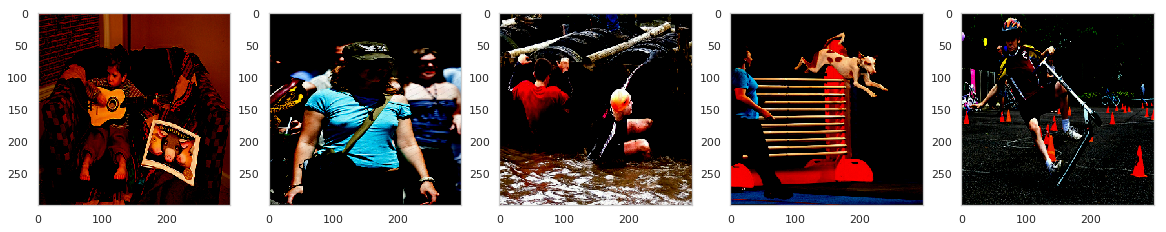

In [39]:
Display_Images = preprocessed_img[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)

for ax, image in zip(axes, Display_Images):
    print('Shape after resize: ', image.shape)
    ax.imshow(image)
    ax.grid('off')

Let's write a function for preprocessing and return images and it's path so that we can use concept of **vectorization and preprocess images paralleley rather than writing for loop**

In [40]:
# write your code here
def preprocess_images_function(image_path):
    img = tf.io.read_file(image_path, name=None)
    #by defaulting channels = 0 which indicates to use the number of channels in the JPEG- encoded image.
    img = tf.image.decode_jpeg(img, channels=0)
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img, data_format=None) # Defaunt value for data_format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    return img, image_path

## Create the train & test data

1.Combine both images & captions to create the train & test dataset using tf.data.Dataset.API. Create the train-test split using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)

In [41]:
all_img_vector

['Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'Flickr8K/Images/1003163366_44323f5815.jpg',
 'Flickr8K/Images/1003163366_44323f5815.jpg',
 'Flickr8K/Images/1003163366_44323f5815.jpg',
 'Flickr8K/Images/1003163366_44323f5815.jpg',
 'Flickr8K/Images/1003163366_44323f5815.jpg',
 'Flickr8K/Images/1007129816_e794419615.jpg',
 'Flickr8K/Images/1007129816_e7944

In [42]:
# Write your code here
# Mapping each image full path including name to the function to preprocess the image

# sorting and storing unique path in list which will be gien as input
training_list = sorted(set(all_img_vector))

# Creating a Dataset using tf.data.Dataset.from_tensor_slice
New_Image_Data = tf.data.Dataset.from_tensor_slices(training_list)

# Mapping preprocess_image_function across the elements of the above dataset
# num_parallel_calls = tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically
New_Image_Data = New_Image_Data.map(preprocess_images_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)

# Keeping batch size = 64 (64 consecutive elements of this dataset is combined in a single batch).
# We don't want to drop the last batch if it contains element less than 64. So, let's set drop_remainder = False
New_Image_Data = New_Image_Data.batch(64, drop_remainder = False)

In [43]:
New_Image_Data

<BatchDataset shapes: ((None, 299, 299, None), (None,)), types: (tf.float32, tf.string)>

In [44]:
#write your code here
# performing the train-test split using 80-20 ratio and random state = 42

img_train_data, img_test_data, caption_train_data, caption_test_data = train_test_split(all_img_vector, cap_vector, test_size = 0.2, random_state = 42)

In [45]:
print('No. of images in training dataset: ', len(img_train_data))
img_train_data[0:5]

No. of images in training dataset:  32364


['Flickr8K/Images/359082432_c1fd5aa2d6.jpg',
 'Flickr8K/Images/2460799229_ce45a1d940.jpg',
 'Flickr8K/Images/3634828052_3b6aeda7d6.jpg',
 'Flickr8K/Images/2216568822_84c295c3b0.jpg',
 'Flickr8K/Images/3080056515_3013830309.jpg']

In [46]:
print('No. of images in testing dataset: ', len(img_test_data))
img_test_data[0:5]

No. of images in testing dataset:  8091


['Flickr8K/Images/2973269132_252bfd0160.jpg',
 'Flickr8K/Images/270263570_3160f360d3.jpg',
 'Flickr8K/Images/2053006423_6adf69ca67.jpg',
 'Flickr8K/Images/512101751_05a6d93e19.jpg',
 'Flickr8K/Images/3156406419_38fbd52007.jpg']

In [47]:
print('No. of captions in training dataset: ', len(caption_train_data))
caption_train_data[0:5]

No. of captions in training dataset:  32364


array([[   2,   11,    8,    9,   17,   39,    6,  146,  148,  110,  542,
          46,   20,    5,  170,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,    5,   47,   95,  238,   17,   21,  472,  543,   17,   90,
          63,    5,   24,    3,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   18,   10,   94,   10,  283,  195, 2640,  278,  140,    3,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   18,   10,   26, 2236,  168,    8, 1869,  455, 1056,    6,
          62,  325,    3,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   80,   42,    7, 3255,   20,   72,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        

In [48]:
print('No. of images in testing dataset: ', len(caption_test_data))
caption_test_data[0:5]

No. of images in testing dataset:  8091


array([[   2,   54, 1626,  588,    7, 4556,  223,  121, 1476,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   13,   27,   31,  500,    6,    5, 1681,  170,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   11,    4,  164,    7,   39,    6,   82,   90,   87,   23,
           5,  458,   74,    5, 3975,    3,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,  887,   14,    9,    7,   32,    6,    5,   41,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   42,  376,  727,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [49]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

In [50]:
# write your code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created we need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

**Note:** We are not classifying the images here, there is no need to have the softmax layer at the end.

**Extracting features from each image in the dataset**

In [51]:
# We are using tqdm for progress bar
image_features_dict={}
for image, image_path in tqdm(New_Image_Data):
    features_for_batch = image_features_extract_model(image) # feed images from newly created Dataset above to Inception V3 built above.
    features_for_batch_flattened = tf.reshape(features_for_batch,
                                              (features_for_batch.shape[0], -1, features_for_batch.shape[3])) # Features in a batch
    
    for batch_feat, path in zip(features_for_batch_flattened, image_path):
        feature_path = path.numpy().decode('utf-8')
        image_features_dict[feature_path] = batch_feat.numpy()

127it [09:29,  3.70s/it]


In [52]:
features_for_batch

<tf.Tensor: shape=(27, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.0000000e+00, 7.7467650e-02, 0.0000000e+00, ...,
          2.3183759e-01, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          1.0778813e-01, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 1.9403169e-01, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.8575513e-01],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          9.4265595e-02, 0.0000000e+00, 5.0578970e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

        [[0.0000000e+00, 4.2300537e-01, 1.3446197e-02, ...,
          2.3367137e-01, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          4.9979120e-02, 0.0000000e+00, 0.0000000e+00]

In [53]:
features_for_batch_flattened

<tf.Tensor: shape=(27, 64, 2048), dtype=float32, numpy=
array([[[0.0000000e+00, 7.7467650e-02, 0.0000000e+00, ...,
         2.3183759e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.0778813e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.9403169e-01, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 1.8575513e-01],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 1.6569363e+00, 0.0000000e+00],
        [0.0000000e+00, 4.0261021e-01, 0.0000000e+00, ...,
         0.0000000e+00, 3.1791839e-01, 0.0000000e+00],
        [0.0000000e+00, 2.5347540e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.2506025e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 7.8497171e-02, ...,
         1.2064208e+00, 0.0000000e+00, 0.0000000e+00],
        [0.000000

In [54]:
len(image_features_dict)

8091

In [55]:
batch_feat.shape

TensorShape([64, 2048])

In [56]:
import more_itertools
top_5_items = more_itertools.take(5, image_features_dict.items())

top_5_items 

[('Flickr8K/Images/1000268201_693b08cb0e.jpg',
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.1698712 ],
         [0.        , 0.        , 1.0105925 , ..., 0.        , 0.        ,
          0.06111747],
         ...,
         [0.        , 0.        , 2.038041  , ..., 1.2029699 , 0.        ,
          1.992411  ],
         [0.        , 0.        , 0.9046886 , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 1.2527242 , 0.        , ..., 0.        , 0.        ,
          0.        ]], dtype=float32)),
 ('Flickr8K/Images/1001773457_577c3a7d70.jpg',
  array([[0.        , 0.66367984, 0.46286014, ..., 0.        , 0.        ,
          3.3322585 ],
         [0.        , 1.2268146 , 0.        , ..., 0.        , 0.25390285,
          3.3295312 ],
         [1.2881926 , 1.5195405 , 0.        , ..., 0.46777815, 0.3647463 ,
          3.817

In [57]:
# We need to give both images and caption to model as input
def model_input(image, captions):
    image_final = image_features_dict[image.decode('utf-8')]
    return image_final, captions

In [58]:
# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences)
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).

BUFFER_SIZE = 1000

# Batch size
BATCH_SIZE = 64 #tried with different batch sizes. kernel is dying for 32. So, finally fixed 64.

def data_generator(images_data, captions_data):
    
    # Creating a Dataset using tf.data.Dataset.from_tensor_slice
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(model_input, [item1, item2], [tf.float32, tf.int32]),
                         num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
    dataset = (
    dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.experimental.AUTOTUNE)
    )
    
    return dataset

In [59]:
train_dataset = data_generator(img_train_data, caption_train_data)
test_dataset = data_generator(img_test_data, caption_test_data)

In [60]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)
print(sample_cap_batch.shape)

(64, 64, 2048)
(64, 31)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [61]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(img_train_data)//BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(img_test_data)//BATCH_SIZE #len(total test images) // BATCH_SIZE
max_length = 31
features_shape = batch_feat.shape[1]
attention_features_shape = batch_feat.shape[0]

In [62]:
train_num_steps

505

In [63]:
test_num_steps

126

### Encoder

In [64]:
tf.compat.v1.reset_default_graph() #to resolve compatibility issue

In [65]:
print(tf.compat.v1.get_default_graph())

In [66]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.keras.activations.relu(features, alpha = 0.01, max_value=None, threshold=0)
        return features

In [67]:
encoder=Encoder(embedding_dim)

In [68]:
encoder

In [69]:
#from keras.utils.vis_utils import plot_model
#plot_model(encoder, to_file = 'model_plot.png', show_shapes = True, show_layer_names=True)

### Attention model

Attention is an interface connecting the encoder and decoder that provides the decoder with information from every encoder hidden state. The model is hence able to selectively focus on valuable parts of the input sequence and hence, learn the association between them.

The attention model produces an output(context vector) that is fed to the decoder for predicting the word at that timestamp. Context vector is adaptive in nature and changes for each timestamp. It makes the model faster and increase it's prediction accuracy.

In [70]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = hidden[:, tf.newaxis]  # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = tf.keras.activations.softmax(self.V(score), axis = 1)  # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features  #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis = 1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

**Notes:**
    
1. Attention model does a linear transformation of input. tanh on top of attention model introduces non-linearities and helps in achieving a smoother distribution.
2. The features produced from fully connected dense layer of encoder and the hidden state of decoder are fed to tanh function and attention score is calculated.
3. As we require an output in range(0,1) we will apply softmax function to attention score and get the final attention weights.

### Decoder

In [71]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [72]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [73]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [74]:
optimizer = tf.keras.optimizers.Adam(lr = 0.001) #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE) #define your loss object

In [75]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [76]:
checkpoint_path = "Flickr8K/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [77]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [78]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        encoder_output = encoder(img_tensor)
        for t in range(1, target.shape[1]):
            predictions, hidden, _ =decoder(dec_input, encoder_output, hidden)
            loss += loss_function(target[:,t], predictions)
            dec_input = tf.expand_dims(target[:,t], 1)
    avg_loss = (loss/int(target.shape[1]))
    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, tot_trainables_variables)
    optimizer.apply_gradients(zip(gradients, tot_trainables_variables))
        
    return loss, avg_loss

In [79]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        encoder_output = encoder(img_tensor)
        
        for t in range(1, target.shape[1]):
            predictions, hidden, _ =decoder(dec_input, encoder_output, hidden)
            loss += loss_function(target[:,t], predictions)
            dec_input = tf.expand_dims(target[:,t], 1)
            
    avg_loss = (loss/int(target.shape[1]))
        
    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, tot_trainables_variables)
    optimizer.apply_gradients(zip(gradients, tot_trainables_variables))
    #write your code here to do the testing steps
        
    return loss, avg_loss

In [80]:
def test_loss_cal(test_dataset):
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss = total_loss/test_num_steps

    #write your code to get the average loss result on your test data
    
    return avg_test_loss

In [81]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.446, & test loss is 1.203
Time taken for 1 epoch 791.9630000591278 sec

Test loss has been reduced from 100.000 to 1.203


 13%|█▎        | 2/15 [24:23<2:43:45, 755.81s/it]

For epoch: 2, the train loss is 1.111, & test loss is 1.057
Time taken for 1 epoch 670.8538365364075 sec

Test loss has been reduced from 1.203 to 1.057


 20%|██        | 3/15 [35:21<2:25:19, 726.59s/it]

For epoch: 3, the train loss is 1.005, & test loss is 0.969
Time taken for 1 epoch 658.3049132823944 sec

Test loss has been reduced from 1.057 to 0.969


 27%|██▋       | 4/15 [46:18<2:09:24, 705.83s/it]

For epoch: 4, the train loss is 0.931, & test loss is 0.904
Time taken for 1 epoch 657.2967977523804 sec

Test loss has been reduced from 0.969 to 0.904


 33%|███▎      | 5/15 [57:11<1:54:58, 689.84s/it]

For epoch: 5, the train loss is 0.870, & test loss is 0.846
Time taken for 1 epoch 652.4216885566711 sec

Test loss has been reduced from 0.904 to 0.846


 40%|████      | 6/15 [1:07:58<1:41:33, 677.03s/it]

For epoch: 6, the train loss is 0.816, & test loss is 0.795
Time taken for 1 epoch 647.0070683956146 sec

Test loss has been reduced from 0.846 to 0.795


 47%|████▋     | 7/15 [1:18:53<1:29:22, 670.26s/it]

For epoch: 7, the train loss is 0.768, & test loss is 0.748
Time taken for 1 epoch 654.3772835731506 sec

Test loss has been reduced from 0.795 to 0.748


 53%|█████▎    | 8/15 [1:29:47<1:17:37, 665.39s/it]

For epoch: 8, the train loss is 0.722, & test loss is 0.703
Time taken for 1 epoch 653.9152820110321 sec

Test loss has been reduced from 0.748 to 0.703


 60%|██████    | 9/15 [1:40:45<1:06:20, 663.42s/it]

For epoch: 9, the train loss is 0.682, & test loss is 0.662
Time taken for 1 epoch 658.6942758560181 sec

Test loss has been reduced from 0.703 to 0.662


 67%|██████▋   | 10/15 [1:51:45<55:10, 662.12s/it] 

For epoch: 10, the train loss is 0.644, & test loss is 0.624
Time taken for 1 epoch 658.9968748092651 sec

Test loss has been reduced from 0.662 to 0.624


 73%|███████▎  | 11/15 [2:02:45<44:06, 661.72s/it]

For epoch: 11, the train loss is 0.607, & test loss is 0.589
Time taken for 1 epoch 660.6706900596619 sec

Test loss has been reduced from 0.624 to 0.589


 80%|████████  | 12/15 [2:13:50<33:07, 662.61s/it]

For epoch: 12, the train loss is 0.575, & test loss is 0.559
Time taken for 1 epoch 664.5772182941437 sec

Test loss has been reduced from 0.589 to 0.559


 87%|████████▋ | 13/15 [2:24:54<22:05, 662.94s/it]

For epoch: 13, the train loss is 0.544, & test loss is 0.531
Time taken for 1 epoch 663.5909674167633 sec

Test loss has been reduced from 0.559 to 0.531


100%|██████████| 15/15 [2:46:57<00:00, 662.14s/it]

For epoch: 15, the train loss is 0.497, & test loss is 0.477
Time taken for 1 epoch 659.5386109352112 sec

Test loss has been reduced from 0.503 to 0.477


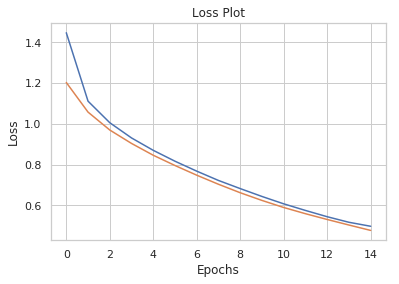

In [82]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [83]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_images_function(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() #extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id]) #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [84]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [85]:
from nltk.translate.bleu_score import sentence_bleu

In [86]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [87]:
img_test = img_test_data.copy()

In [105]:
#modifying the given code as function to run it several times by changing weights
def predicted_caption_audio(random, autoplay=False, weights=(0.5, 0.5 , 0, 0)):
    cap_test = caption_test_data.copy()
    rid = np.random.randint(0, random)
    test_image = img_test[rid]
    #test_image = './images/413231421_43833a11f5.jpg'
    #real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)


    real_caption=filt_text(real_caption)      


    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights= weights) #set your weights)
    print(f"BELU score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attmap(result, attention_plot, test_image)


    #Let's use google text to speech online API from playing the predicted caption as audio
    speech = gTTS('Predicted Caption is: '+ pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'
    display.display(display.Audio(audio_file, rate=None, autoplay=autoplay))
    
    return test_image

BELU score: 27.455024338805618
Real Caption: two brown dogs fight on the leafy ground
Prediction Caption: two brown and white dogs play roughly in clearing of wooded area


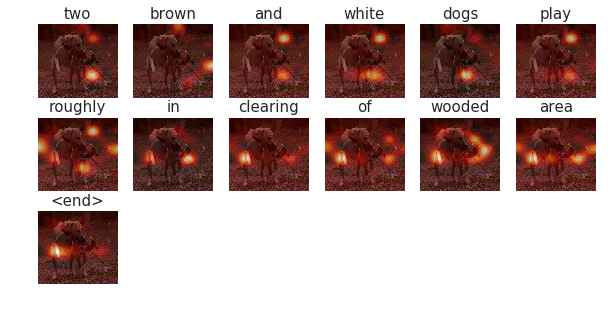

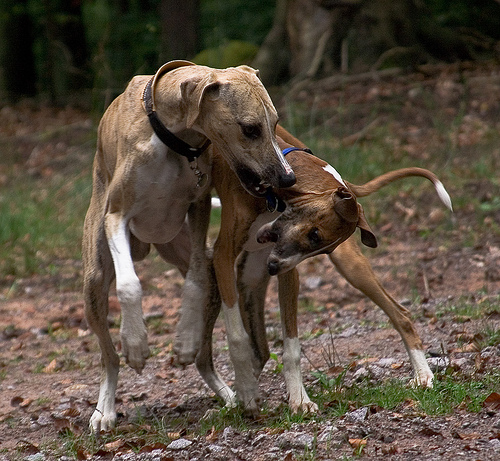

In [114]:
test_image = predicted_caption_audio(5, True, weights=(0.5,0.25,0,0))
Image.open(test_image)

BELU score: 6.378233182772391e-76
Real Caption: two asian girls are standing outside red brick building
Prediction Caption: two women stop to their heads down the stairs outside building


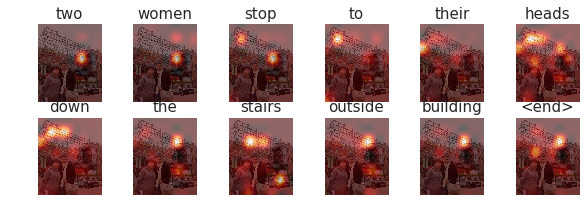

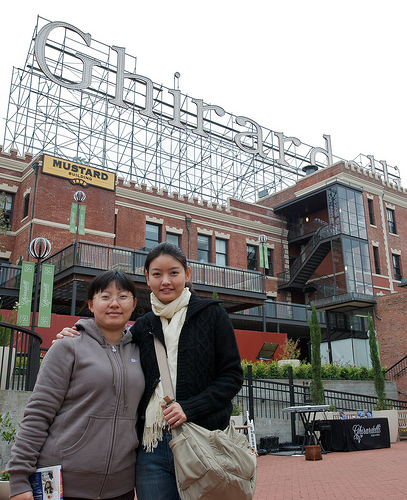

In [116]:
test_image = predicted_caption_audio(len(img_test), False, weights=(0.5,0.25,0,0))
Image.open(test_image)

BELU score: 63.48761284611546
Real Caption: brown and white dog rolling around on the grass
Prediction Caption: dog rolling on its back on the grass


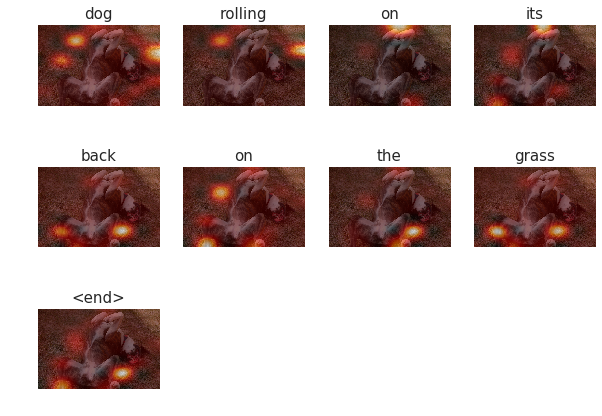

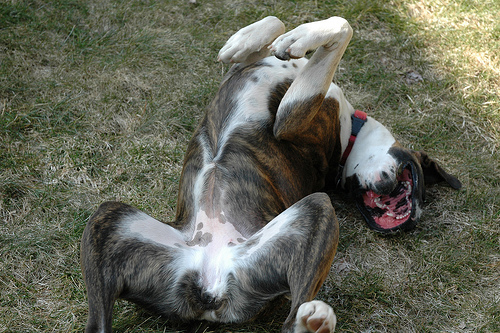

In [117]:
test_image = predicted_caption_audio(len(img_test), False, weights=(0.25,0.25,0,0))
Image.open(test_image)

BELU score: 23.978314673389146
Real Caption: crowd gathers behind an older man
Prediction Caption: group of friends are standing in front of an older people


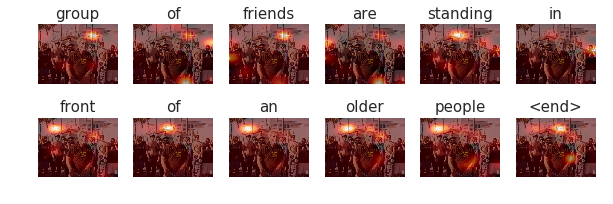

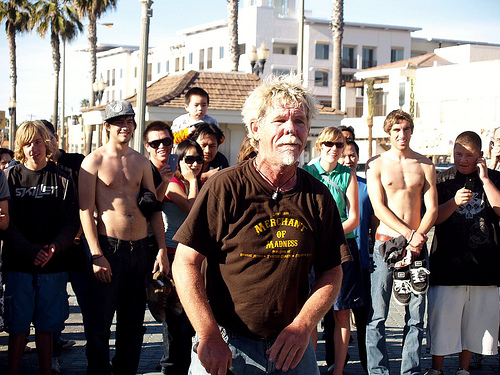

In [118]:
test_image = predicted_caption_audio(len(img_test), False, weights=(0.5,0.25,0,0))
Image.open(test_image)

BELU score: 100.0
Real Caption: person wearing clothes with floral pattern leans on trashcan cage
Prediction Caption: person wearing clothes with floral pattern leans on trashcan cage


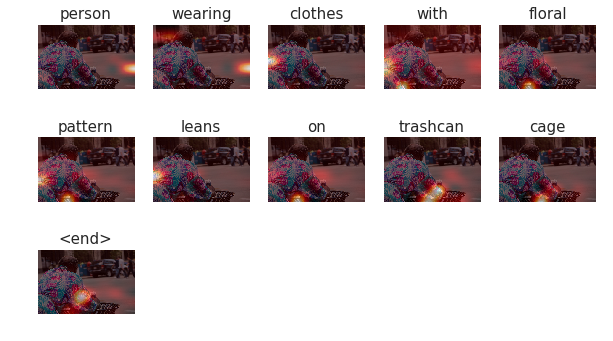

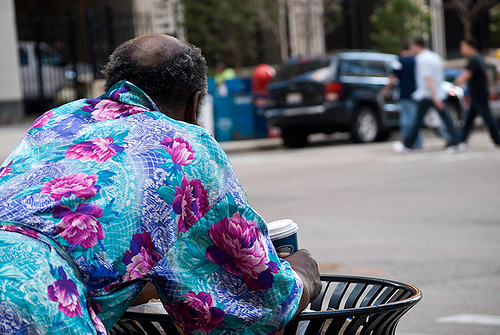

In [119]:
test_image = predicted_caption_audio(len(img_test), False, weights=(0.5,0.5,0,0))
Image.open(test_image)

## Summary

The project started with reading images and captions, displaying them. EDA is performed to understand about the given dataset. Data cleaning is done which included cleaning caption file.

Data preprocessing is also performed which included:

- tokenizing the captions and forming an embeded vector.
- preprocessing images

Post that the dataset is splitted into train & test dataset.

InceptionV3 model is used. InceptionV3 is a widely-used image recognition model that has been shown to aattain greater than 78.1% accuracy on the ImageNet dataset. So let's also use same model to get feature vector.

Hence in this project, we are not classifying the images. Rather, we only need to extract a feature vector for our images. Hence we are removing the softmax layer from the model. The shape of the output of this layer is 8x8x2048. Then we squeezed that to a shape of (64,2048).

This feature vector is given as input to CNN Encoder which had a single fully connnected layer. To tell in abstract way, we can say that output from the encoder, hidden state(initialize to 0), and start token is passed as input to the decoder.

The decoder (RNN-here GRU) attends over the image to predict the next word. We used the attention model to make our decoder focus on a particular part of the image at a time rather that focusing on the entire image. This also reduces noise and improves accuracy. The decoder returns the predicted caption and the decoder's hidden state as output, which is sent back to the model and the predictions are used to calculate the loss using cross-entropy.
'SparseCategoricalCrossentropy'. We alse used teacher forcing to decide the next input to the decoder.

The decpder stop predicting when the model predicts the end token.

The predoction of the words by the model is done by finding out the probabilities of that word in the vocabulary. We are using the greedy search method. It calculates the probability of the words according to their occurrence in the vocabulary. It takes the sample of the words, finds the probability of each word, and then outputs the word with the highest probability.

Finally, we are using the 'BLEU score'(Bilingual Evaluation Understudy) as the evaluation metric for the predicted word. It determines the difference between the predicted caption and the real caption.